# Predicting Business Outcomes Using Yelp Reviews and Business Metadata


This project will analyze historical Yelp data to identify key factors that distinguish successful, long-lasting businesses from those that eventually close down. The goal is to build a predictive model that can assess a business's risk of failure based on its early-life signals on the platform.


## 1. Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

## 2. Load Data

In [3]:
files = {
    "business": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/yelp_academic_dataset_business.json",
    "checkin": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/yelp_academic_dataset_checkin.json",
    "photos": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/photos.json",
    "review": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/yelp_academic_dataset_review.json",
    "tip": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/yelp_academic_dataset_tip.json",
    "user": "/content/drive/MyDrive/DAB322_Capstone 1_Group 9/Yelp_Datasets/Original_JSON_files/yelp_academic_dataset_user.json"
}

# limit the number of rows
limit = 80000

datasets = {}
for name, path in files.items():
    df = pd.read_json(path, lines=True, nrows=limit)
    datasets[name] = df
    print(f"{name}: {len(df)} rows read")

# files name
business = datasets["business"]
checkin = datasets["checkin"]
photos = datasets["photos"]
review = datasets["review"]
tip = datasets["tip"]
user = datasets["user"]

business: 80000 rows read
checkin: 80000 rows read
photos: 80000 rows read
review: 80000 rows read
tip: 80000 rows read
user: 80000 rows read


## 3. Data Overview

### Business Data

In [4]:
business.info()
business.head()
business.isnull().sum()
business.describe()
business['categories'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   80000 non-null  object 
 1   name          80000 non-null  object 
 2   address       80000 non-null  object 
 3   city          80000 non-null  object 
 4   state         80000 non-null  object 
 5   postal_code   80000 non-null  object 
 6   latitude      80000 non-null  float64
 7   longitude     80000 non-null  float64
 8   stars         80000 non-null  float64
 9   review_count  80000 non-null  int64  
 10  is_open       80000 non-null  int64  
 11  attributes    72775 non-null  object 
 12  categories    79947 non-null  object 
 13  hours         67684 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 8.5+ MB


,count
categories,
"Beauty & Spas, Nail Salons",513
"Restaurants, Pizza",469
"Nail Salons, Beauty & Spas",469
"Pizza, Restaurants",455
"Restaurants, Chinese",395
...,...
"Appliances & Repair, Shopping, Home & Garden, Hardware Stores, Local Services, Home Services, Building Supplies, Contractors, Appliances, Nurseries & Gardening",1
"Restaurants, Sandwiches, Breakfast & Brunch, Steakhouses, Comfort Food, Burgers",1
"Cocktail Bars, Bars, Beer Bar, Nightlife, Music Venues, Arts & Entertainment",1


### Checkin Data

In [5]:
checkin.head()
checkin.info()
checkin.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  80000 non-null  object
 1   date         80000 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,0
business_id,0
date,0


### User Data

In [6]:
user.info()
user.head(10)
user.isnull().sum()
user.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             80000 non-null  object 
 1   name                80000 non-null  object 
 2   review_count        80000 non-null  int64  
 3   yelping_since       80000 non-null  object 
 4   useful              80000 non-null  int64  
 5   funny               80000 non-null  int64  
 6   cool                80000 non-null  int64  
 7   elite               80000 non-null  object 
 8   friends             80000 non-null  object 
 9   fans                80000 non-null  int64  
 10  average_stars       80000 non-null  float64
 11  compliment_hot      80000 non-null  int64  
 12  compliment_more     80000 non-null  int64  
 13  compliment_profile  80000 non-null  int64  
 14  compliment_cute     80000 non-null  int64  
 15  compliment_list     80000 non-null  int64  
 16  comp

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,105.252350,258.949988,110.985362,158.059025,8.90440,3.858785,11.320863,1.844013,1.213763,0.838387,0.498075,8.859288,20.062550,17.929500,17.929500,7.273038,6.185812
std,258.167414,1821.486859,1180.987783,1561.391419,64.13221,0.643144,137.593105,24.275875,35.209503,14.030645,14.016817,77.750325,264.741345,192.494866,192.494866,78.529912,116.468333
min,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,9.000000,1.000000,2.000000,0.00000,3.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.000000,32.000000,7.000000,9.000000,1.00000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,94.000000,119.000000,31.000000,40.000000,4.00000,4.250000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000
max,17473.000000,206296.000000,185823.000000,195814.000000,12497.00000,5.000000,12391.000000,4347.000000,7039.000000,1744.000000,2607.000000,8616.000000,28974.000000,13280.000000,13280.000000,9821.000000,14045.000000


### Tip Data

In [7]:
tip.head()
tip.isnull().sum()
tip.describe()
tip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           80000 non-null  object        
 1   business_id       80000 non-null  object        
 2   text              80000 non-null  object        
 3   date              80000 non-null  datetime64[ns]
 4   compliment_count  80000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.1+ MB


### Review Data

In [8]:
review.info()
review.head(10)
review.isnull().sum()
review.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    80000 non-null  object        
 1   user_id      80000 non-null  object        
 2   business_id  80000 non-null  object        
 3   stars        80000 non-null  int64         
 4   useful       80000 non-null  int64         
 5   funny        80000 non-null  int64         
 6   cool         80000 non-null  int64         
 7   text         80000 non-null  object        
 8   date         80000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 5.5+ MB


,stars,useful,funny,cool,date
count,80000.000000,80000.00000,80000.000000,80000.000000,80000
mean,3.844512,0.89655,0.257675,0.347212,2015-05-03 02:10:53.944837632
min,1.000000,0.00000,0.000000,0.000000,2005-03-01 17:47:15
25%,3.000000,0.00000,0.000000,0.000000,2013-12-08 04:12:03.500000
50%,4.000000,0.00000,0.000000,0.000000,2015-09-27 03:43:38
75%,5.000000,1.00000,0.000000,0.000000,2017-04-08 14:10:36.500000
max,5.000000,171.00000,98.000000,49.000000,2018-10-04 18:22:35
std,1.353924,1.98193,1.022994,1.061270,NaN


### Photos Data

In [9]:
photos.info()
photos.head(10)
photos.isnull().sum()
photos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   photo_id     80000 non-null  object
 1   business_id  80000 non-null  object
 2   caption      80000 non-null  object
 3   label        80000 non-null  object
dtypes: object(4)
memory usage: 2.4+ MB


,photo_id,business_id,caption,label
count,80000,80000,80000,80000
unique,80000,26366,32301,5
top,m5svD4kUQ3wWAwSTb-ydkw,FEXhWNCMkv22qG04E83Qjg,,food
freq,1,200,41510,43083


## 4. Data Cleaning

### 4.1. Business

In [10]:
# Handle missing values in optional business fields
business['categories'] = business['categories'].fillna('Unknown')
business['address'] = business['address'].fillna('Unknown')
business['postal_code'] = business['postal_code'].fillna('Unknown')
business['attributes'] = business['attributes'].fillna('Unknown')
business['hours'] = business['hours'].fillna('Unknown')

# Standardize text formatting
business['city'] = business['city'].str.title()
business['state'] = business['state'].str.upper()

# Validate star ratings (must be between 0 and 5)
invalid_stars = business[(business['stars'] > 5) | (business['stars'] < 0)]
print(f"Invalid business star ratings:\n{invalid_stars}")

# Extract primary category from category list
business['main_cat'] = business['categories'].apply(
    lambda x: str(x).split(',')[0].strip() if pd.notnull(x) else 'Unknown'
)

# Normalize categories into high-level groups
def map_business_category(category):
    category = str(category).lower()

    if any(k in category for k in ['restaurant', 'food', 'cafe', 'pizza', 'coffee']):
        return 'Food & Beverage'
    if any(k in category for k in ['health', 'clinic', 'fitness', 'spa']):
        return 'Health & Wellness'
    if any(k in category for k in ['hotel', 'inn', 'bnb']):
        return 'Accommodation'
    if any(k in category for k in ['bar', 'nightlife', 'pub']):
        return 'Nightlife'
    if any(k in category for k in ['shop', 'store', 'retail']):
        return 'Retail'
    if any(k in category for k in ['auto', 'car', 'mechanic']):
        return 'Automotive'
    return 'Other'

business['main_cat'] = business['main_cat'].apply(map_business_category)

# Save cleaned business data
business.to_csv('business_cleaned.csv', index=False)


Invalid business star ratings:
Empty DataFrame
Columns: [business_id, name, address, city, state, postal_code, latitude, longitude, stars, review_count, is_open, attributes, categories, hours]
Index: []


### 4.2. Photos

In [11]:
# Fill missing optional text fields
photos['caption'] = photos['caption'].fillna('No caption')
photos['label'] = photos['label'].fillna('Unknown')

# Ensure identifier fields are stored as strings
photos['photo_id'] = photos['photo_id'].astype(str)
photos['business_id'] = photos['business_id'].astype(str)

# Remove duplicate photo records
photos = photos.drop_duplicates(subset='photo_id')

# Save cleaned photos dataset
photos.to_csv('photos_cleaned.csv', index=False)

print("Photos dataset cleaned and saved.")


Photos dataset cleaned and saved.


### 4.3. Review

In [12]:
# Keep only relevant columns
review = review[['review_id', 'user_id', 'business_id', 'stars', 'text', 'date']]

# Fill missing values (text + stars)
review['text'] = review['text'].fillna('No review text')
review['stars'] = review['stars'].fillna(0)

# Convert date to datetime
review['date'] = pd.to_datetime(review['date'], errors='coerce')

# Ensure ID columns are strings
review['review_id'] = review['review_id'].astype(str)
review['user_id'] = review['user_id'].astype(str)
review['business_id'] = review['business_id'].astype(str)

# Remove duplicate reviews
review = review.drop_duplicates(subset='review_id')

# Save cleaned review dataset
review.to_csv('review_cleaned.csv', index=False)


### 4.4. Checkin

In [13]:
# Split comma-separated check-in timestamps into a list
checkin['date_list'] = checkin['date'].str.split(',')

# Expand list into multiple rows (one row per check-in)
checkin = checkin.explode('date_list')

# Convert to datetime
checkin['checkin_time'] = pd.to_datetime(checkin['date_list'].str.strip(), errors='coerce')

# Drop invalid check-in timestamps
checkin = checkin.dropna(subset=['checkin_time'])

# Extract time features
checkin['year'] = checkin['checkin_time'].dt.year
checkin['month'] = checkin['checkin_time'].dt.month
checkin['day_of_week'] = checkin['checkin_time'].dt.dayofweek
checkin['hour'] = checkin['checkin_time'].dt.hour

# Drop raw columns that are no longer needed
checkin = checkin.drop(columns=['date', 'date_list'])

# Save cleaned check-in dataset
checkin.to_csv('checkin_cleaned.csv', index=False)

### 4.5. User

In [14]:
# Drop high-cardinality column (optional)
user_clean = user.drop(columns=['friends'], errors='ignore')

# Fill missing name and elite fields
user_clean['name'] = user_clean['name'].fillna('Unknown')
user_clean['elite'] = user_clean['elite'].fillna('None')

# Convert yelping_since to datetime
user_clean['yelping_since'] = pd.to_datetime(user_clean['yelping_since'], errors='coerce')

# Remove duplicate users
user_clean = user_clean.drop_duplicates(subset='user_id')

# Save cleaned user dataset
user_clean.to_csv('user_cleaned.csv', index=False)

### 4.6. Tip

In [15]:
# Remove empty tip text
tip = tip[tip['text'].str.strip().notna()]

# Convert date to datetime
tip['date'] = pd.to_datetime(tip['date'], errors='coerce')

# Drop rows missing key identifiers
tip = tip.dropna(subset=['user_id', 'business_id'])

# Remove duplicate tips
tip = tip.drop_duplicates(subset=['user_id', 'business_id', 'text'])

# Save cleaned tip dataset
tip.to_csv('tip_cleaned.csv', index=False)

## 5. EDA

### 5.1. Business

In [16]:
df = business.copy()
# Create a working copy of the dataset for preprocessing and analysis

print(df.shape)
# Check dataset dimensions to understand data scale

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Extract numeric features for statistical analysis and modeling

cat_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
# Extract categorical features for grouping and encoding

print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)
# Verify feature type classification before further processing

(80000, 15)
Numeric Columns: ['latitude', 'longitude', 'stars', 'review_count', 'is_open']
Categorical Columns: ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'attributes', 'categories', 'hours', 'main_cat']


#### Univariate Analysis

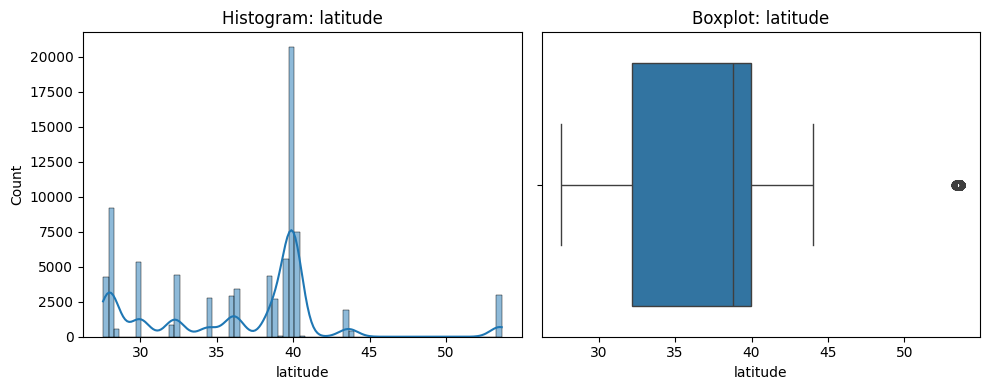

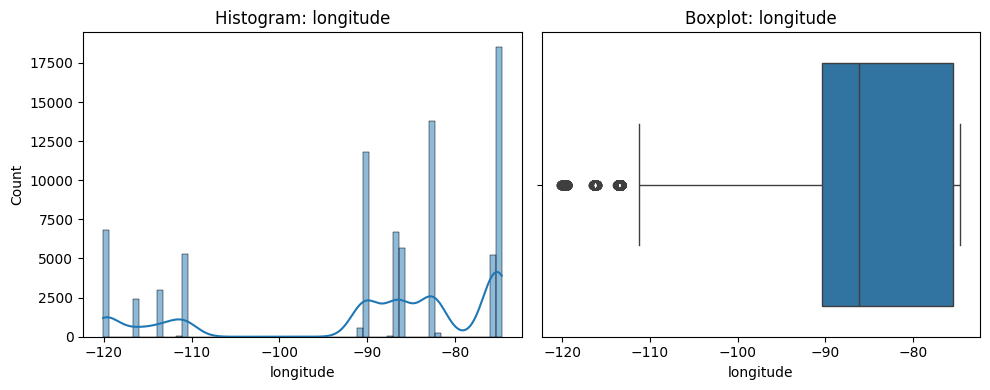

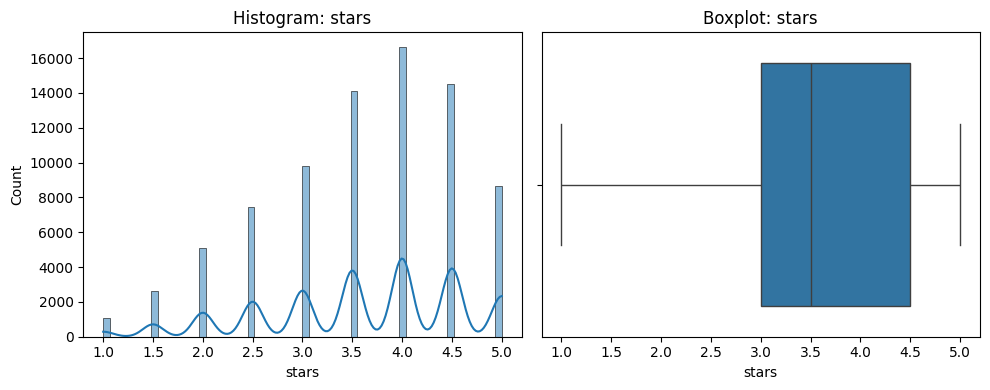

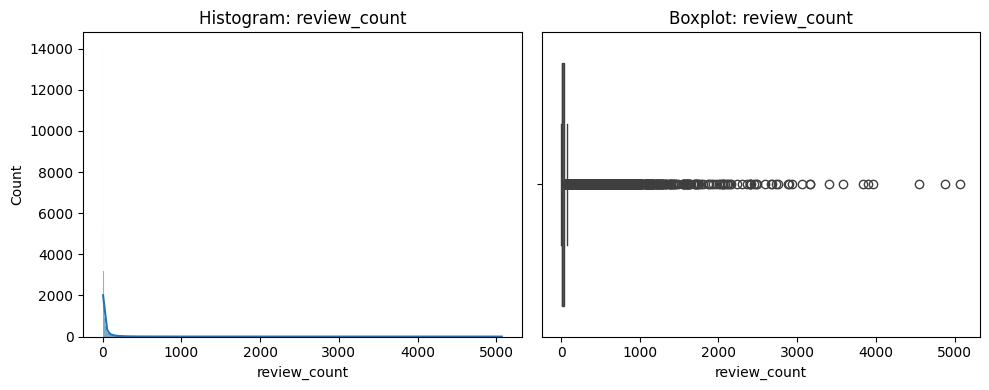

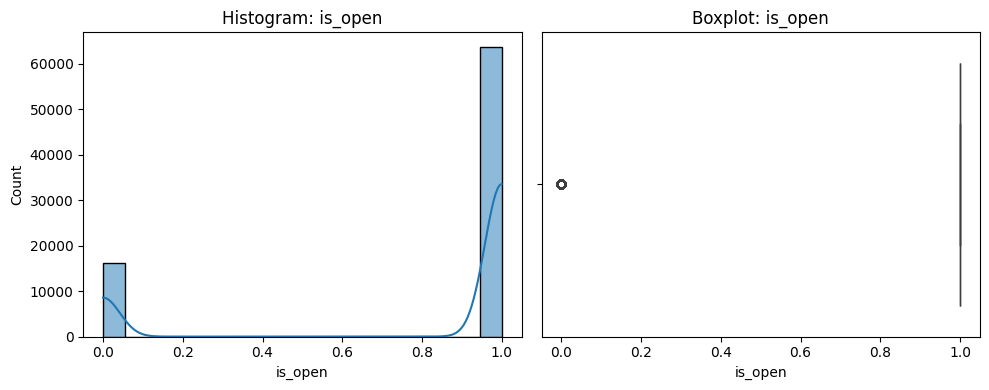

In [17]:
# Summary statistics for numeric variables
df[num_cols].describe().T
# Generate descriptive statistics to understand central tendency and dispersion

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(df[col].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram: {col}")
    # Visualize distribution and skewness of the variable

    sns.boxplot(x=df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot: {col}")
    # Detect outliers and spread using boxplot

    plt.tight_layout()
    plt.show()
    # Display distribution plots for each numeric feature

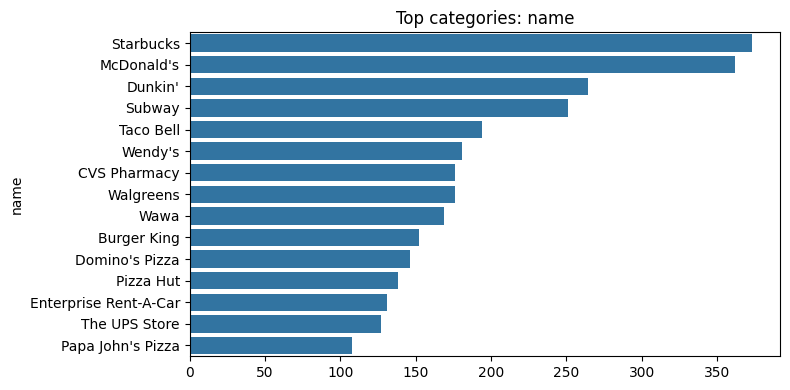

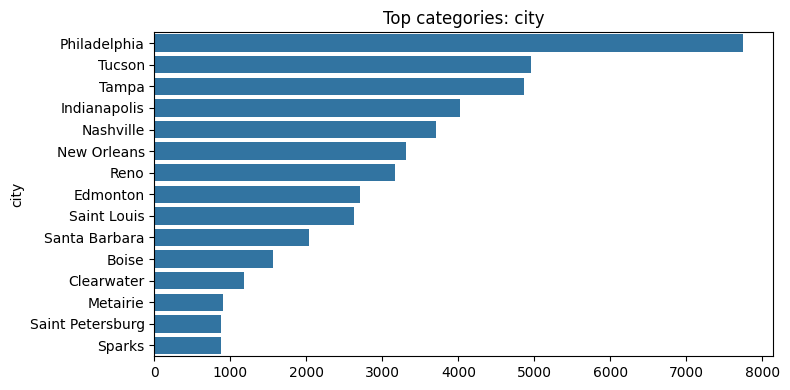

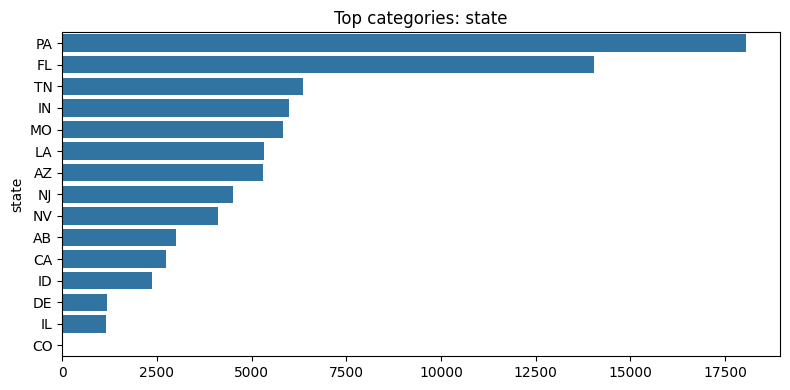

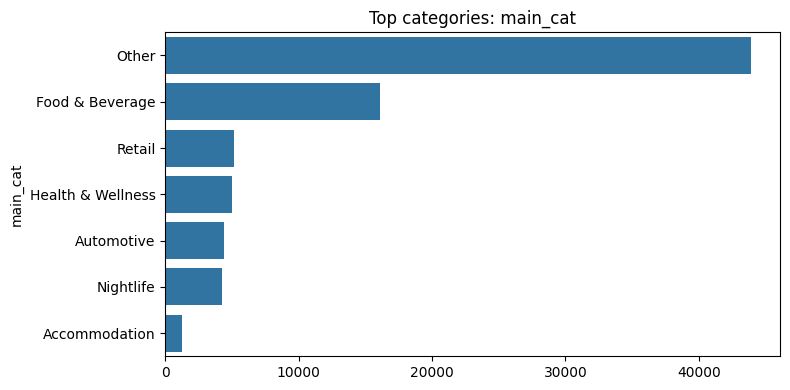

In [18]:
# Select key categorical variables for analysis
cat_cols = [col for col in df.columns if col in ['name', 'city', 'state', 'main_cat']]
# Focus on high-impact categorical features relevant to the project

for col in cat_cols:
    top_vals = df[col].value_counts().head(15)
    # Compute frequency of top 15 most common categories

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_vals.values, y=top_vals.index)
    plt.title(f"Top categories: {col}")
    # Visualize category distribution to identify dominant groups

    plt.tight_layout()
    plt.show()
    # Display bar chart for each categorical variable

#### Bivariate Analysis

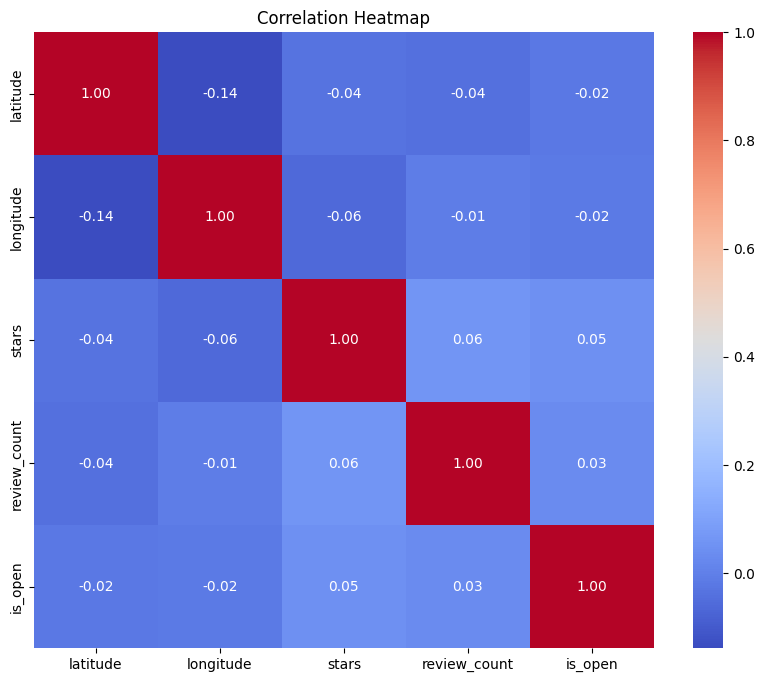

In [19]:
# Analyze relationships between numeric variables
corr = df[num_cols].corr()
# Compute correlation matrix for numeric features

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
# Visualize strength and direction of correlations

plt.title("Correlation Heatmap")
plt.show()
# Identify potential multicollinearity and key feature relationships

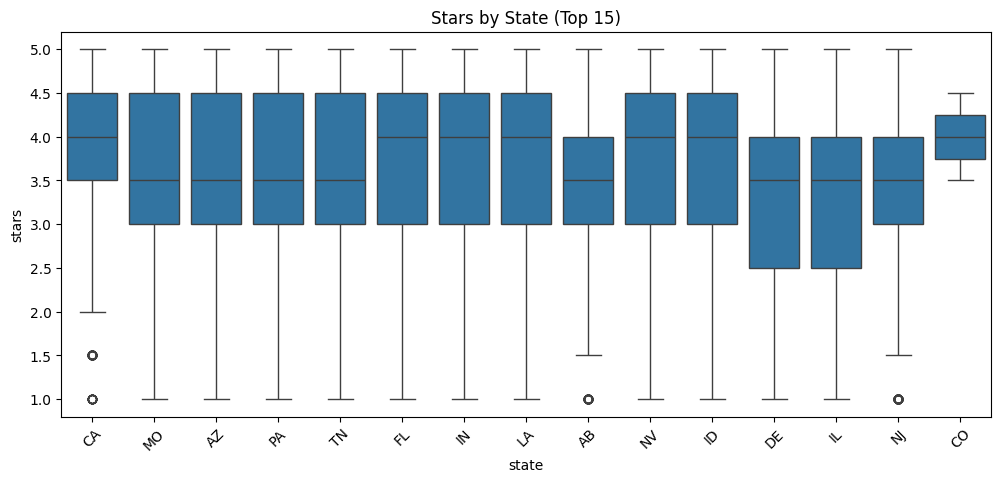

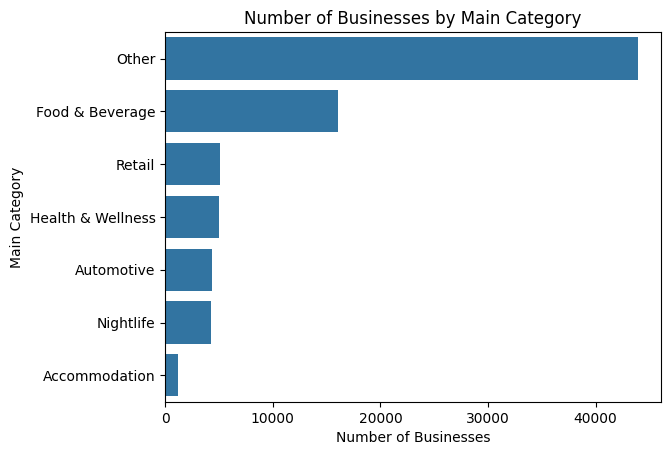

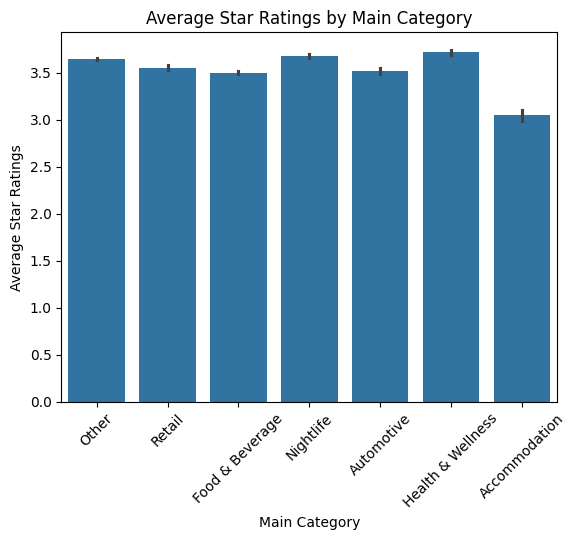

In [20]:
# Numerical vs. Categorical analysis

top_states = df["state"].value_counts().head(15).index
# Select top 15 states with the highest number of businesses

plt.figure(figsize=(12, 5))
sns.boxplot(data=df[df["state"].isin(top_states)], x="state", y="stars")
plt.xticks(rotation=45)
plt.title("Stars by State (Top 15)")
# Compare rating distributions across major states
plt.show()

# Number of businesses by main category
sns.barplot(
    x=business['main_cat'].value_counts().values,
    y=business['main_cat'].value_counts().index
)
plt.title('Number of Businesses by Main Category')
plt.xlabel('Number of Businesses')
plt.ylabel('Main Category')
# Identify dominant business categories
plt.show()

# Average star ratings by main category
sns.barplot(x='main_cat', y='stars', data=business)
plt.title('Average Star Ratings by Main Category')
plt.xlabel('Main Category')
plt.ylabel('Average Star Ratings')
plt.xticks(rotation=45)
# Compare average customer ratings across categories
plt.show()

#### Multivariate Analysis

Explained Variance: [0.2288419  0.22307648]


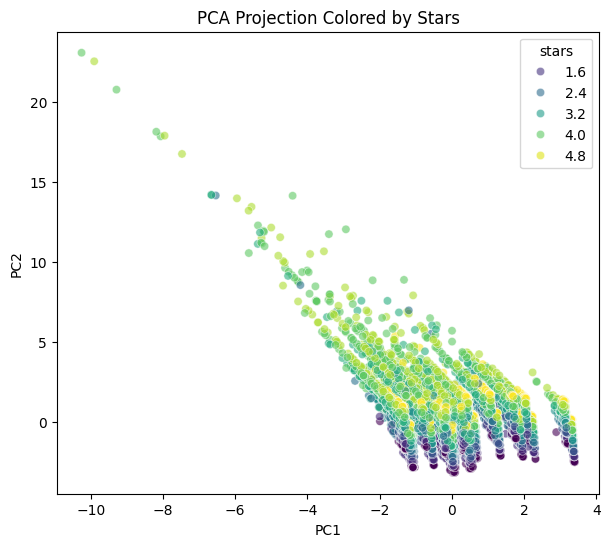

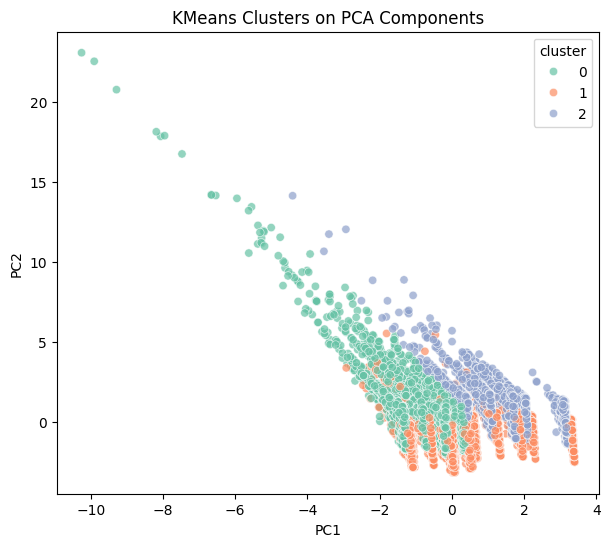

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X = df[num_cols]
# Select numeric features for modeling

# Handle missing values
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)
# Impute missing values using median to reduce outlier influence

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)
# Standardize features to zero mean and unit variance

# PCA: dimensionality reduction
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
# Project data onto first two principal components

df_pca = pd.DataFrame({
    "PC1": pcs[:, 0],
    "PC2": pcs[:, 1],
    "stars": df["stars"]
})
# Create PCA dataframe for visualization

print("Explained Variance:", pca.explained_variance_ratio_)
# Check variance explained by principal components

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="stars", palette="viridis", alpha=0.6
)
plt.title("PCA Projection Colored by Stars")
# Visualize rating patterns in reduced feature space
plt.show()

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
# Cluster businesses based on standardized numeric features

df_pca["cluster"] = labels
# Attach cluster labels to PCA results

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="cluster", palette="Set2", alpha=0.7
)
plt.title("KMeans Clusters on PCA Components")
# Visualize cluster separation in PCA space
plt.show()

### 5.2. Checkin

#### Univariate Analysis

                 count         mean       std     min     25%     50%     75%  \
year         8228611.0  2015.301411  2.761268  2010.0  2013.0  2015.0  2017.0   
month        8228611.0     6.489046  3.398792     1.0     4.0     6.0     9.0   
day_of_week  8228611.0     3.451021  2.002553     0.0     2.0     4.0     5.0   
hour         8228611.0    13.780798  8.116075     0.0     4.0    17.0    20.0   

                max  missing  unique  
year         2022.0        0      13  
month          12.0        0      12  
day_of_week     6.0        0       7  
hour           23.0        0      24  


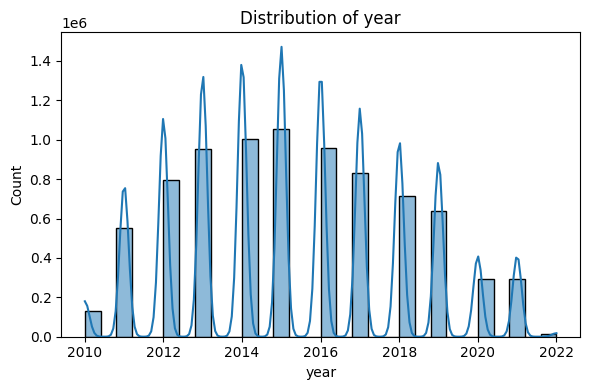

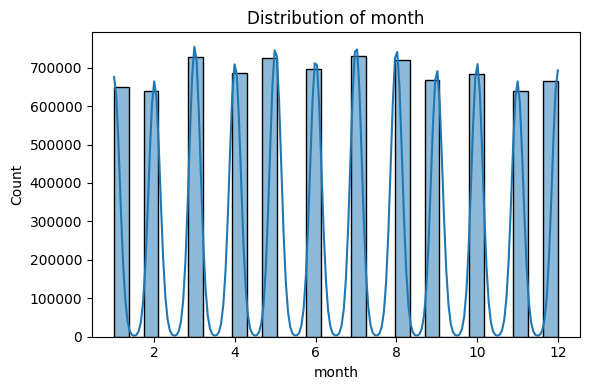

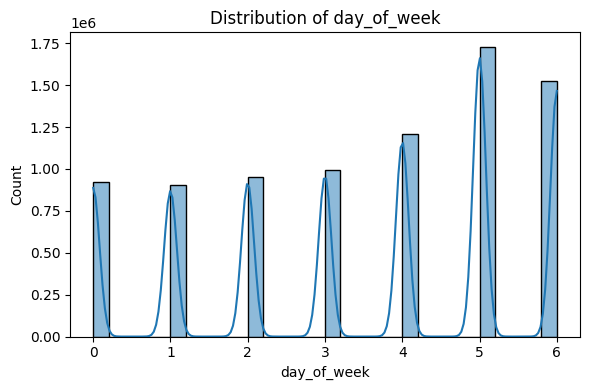

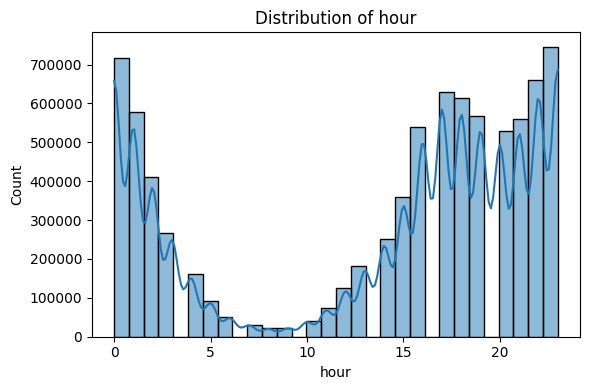

In [22]:
def univariate_analysis(checkin):
    # Perform univariate analysis on numeric time-related features

    numeric_cols = ["year", "month", "day_of_week", "hour"]
    # Select numeric variables for univariate exploration

    # Generate summary statistics
    summary = checkin[numeric_cols].describe().T
    summary["missing"] = checkin[numeric_cols].isna().sum()
    summary["unique"] = checkin[numeric_cols].nunique()
    # Add missing value counts and number of unique values
    print(summary)

    # Visualize distributions
    for col in numeric_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(checkin[col], kde=True, bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        # Examine distribution shape and frequency patterns
        plt.tight_layout()
        plt.show()


univariate_analysis(checkin)
# Execute univariate EDA on the check-in dataset

#### Bivariate Analysis

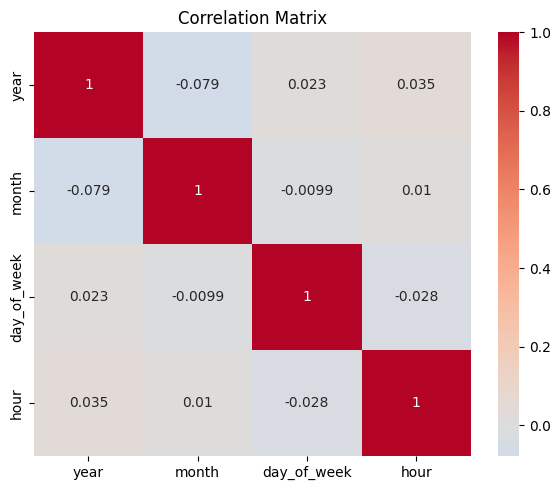

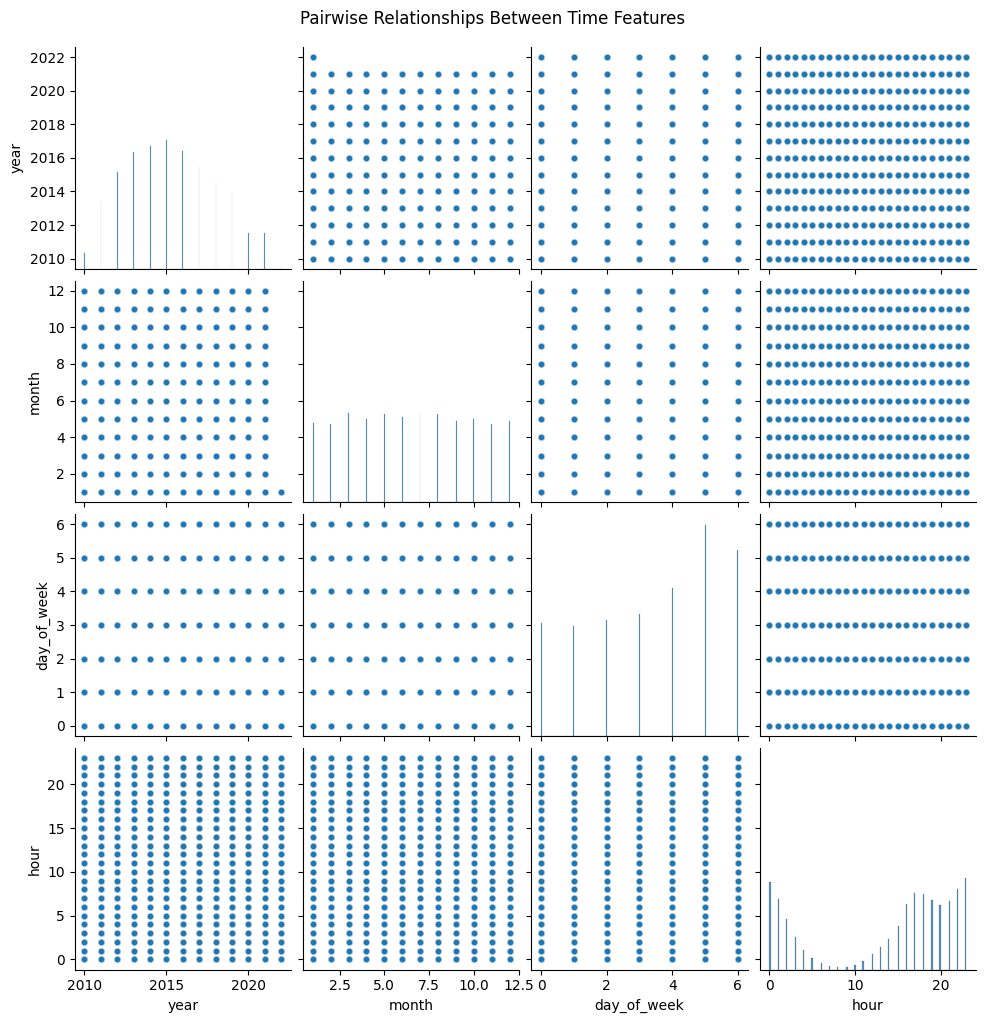

In [23]:
def bivariate_analysis(checkin):
    # Perform bivariate analysis to examine relationships between numeric features

    numeric_cols = ["year", "month", "day_of_week", "hour"]
    # Select numeric time-related variables

    # Correlation matrix
    plt.figure(figsize=(6, 5))
    corr = checkin[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    # Visualize strength and direction of linear relationships
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # Pairwise scatter plots
    sns.pairplot(
        checkin[numeric_cols],
        plot_kws={'alpha': 0.4, 's': 20}
    )
    plt.suptitle("Pairwise Relationships Between Time Features", y=1.02)
    # Explore potential patterns and interactions between variables
    plt.show()


bivariate_analysis(checkin)
# Execute bivariate EDA on the check-in dataset

#### Multivariate Analysis

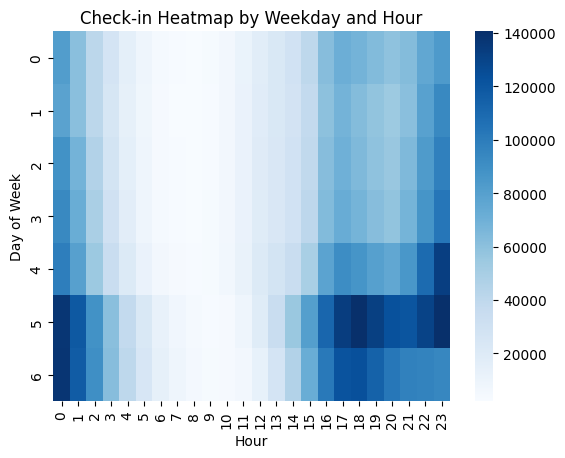

In [24]:
# Analyze relationship between weekday and hour
pivot = checkin.pivot_table(
    index='day_of_week',
    columns='hour',
    values='business_id',
    aggfunc='count'
)
# Aggregate check-ins by day of week and hour

sns.heatmap(pivot, cmap='Blues')
# Visualize temporal patterns in check-ins using a heatmap

plt.title('Check-in Heatmap by Weekday and Hour')
plt.xlabel('Hour')
plt.ylabel('Day of Week')
plt.show()
# Identify peak business activity by time and day

### 5.3. Review

Using already loaded 'review' DataFrame for EDA...
Original shape (after copying loaded review df): (80000, 6)

===== DATA INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    80000 non-null  object        
 1   user_id      80000 non-null  object        
 2   business_id  80000 non-null  object        
 3   stars        80000 non-null  int64         
 4   text         80000 non-null  object        
 5   date         80000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.7+ MB
None

===== MISSING VALUES =====
review_id      0
user_id        0
business_id    0
stars          0
text           0
date           0
dtype: int64

===== STAR DISTRIBUTION =====
stars
5    35527
4    20325
3     9056
1     8726
2     6366
Name: count, dtype: int64


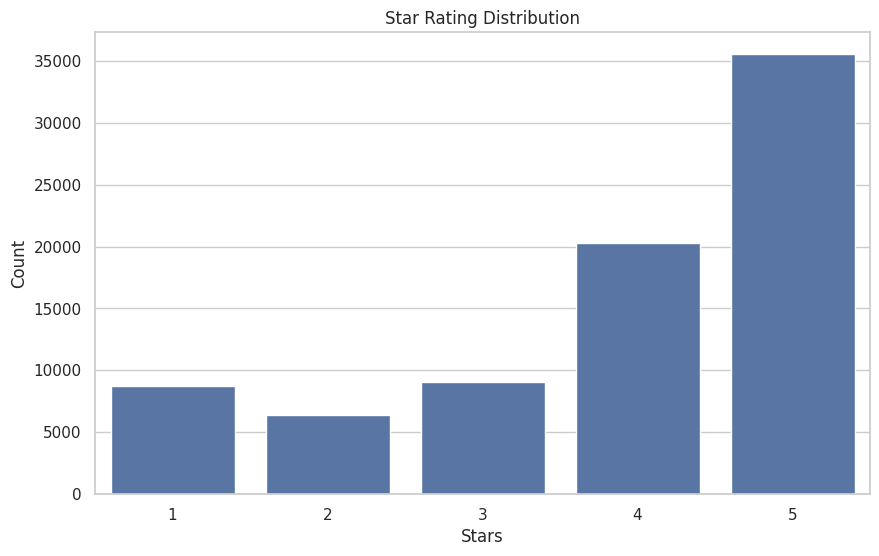


Creating text features...
       review_length    word_count
count   80000.000000  80000.000000
mean      548.967413    101.200137
std       502.414681     93.094355
min         3.000000      1.000000
25%       226.000000     41.000000
50%       395.000000     73.000000
75%       694.000000    128.000000
max      5000.000000   1006.000000


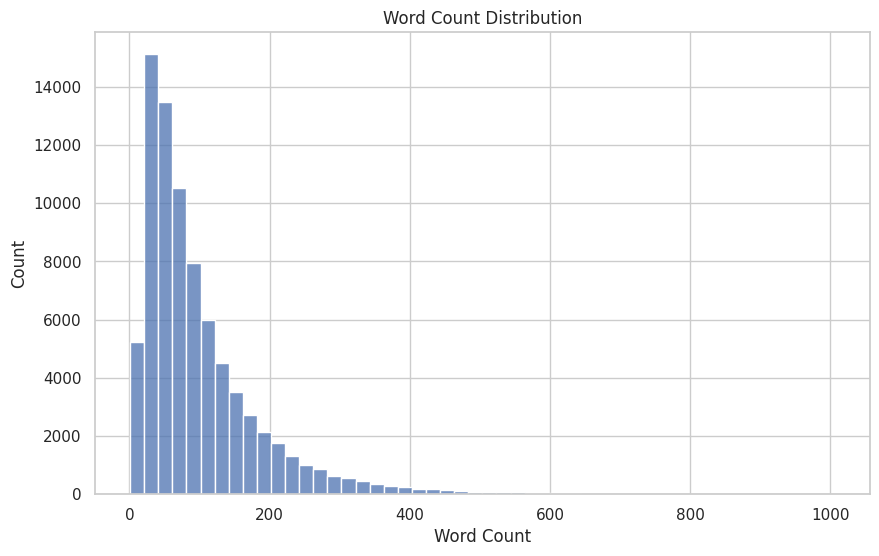


Processing dates...


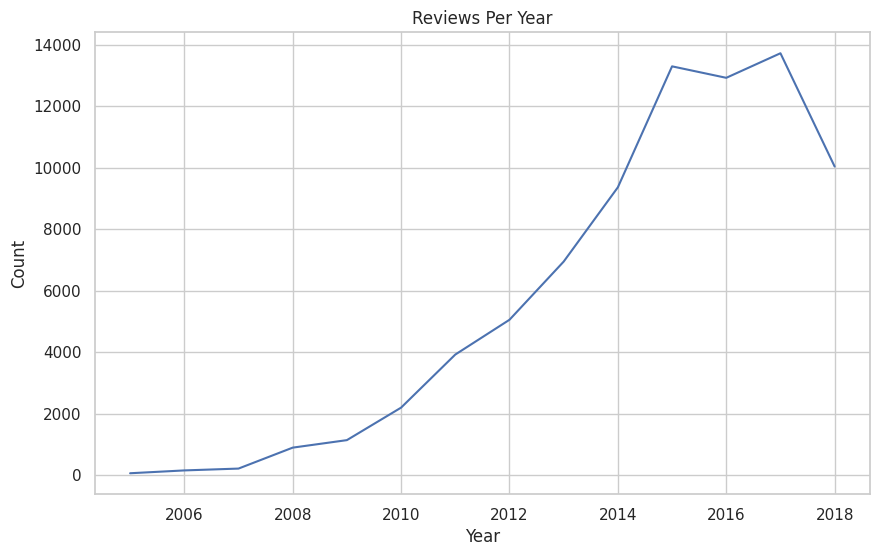

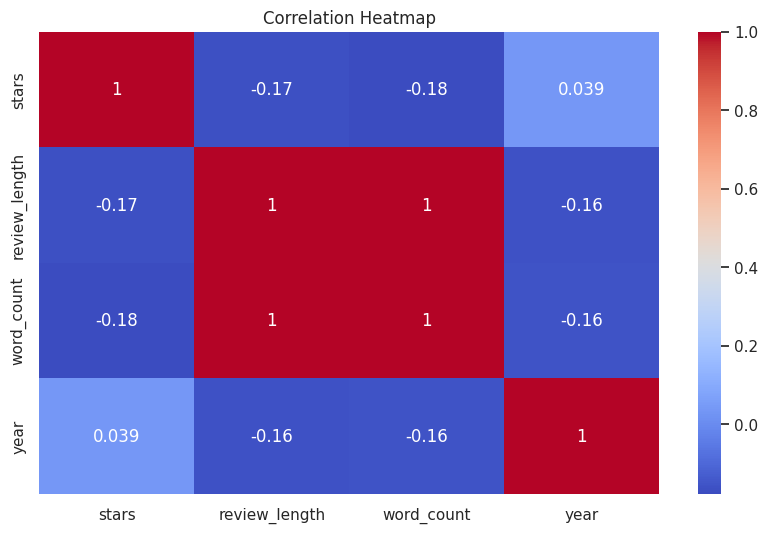


Generating WordCloud...


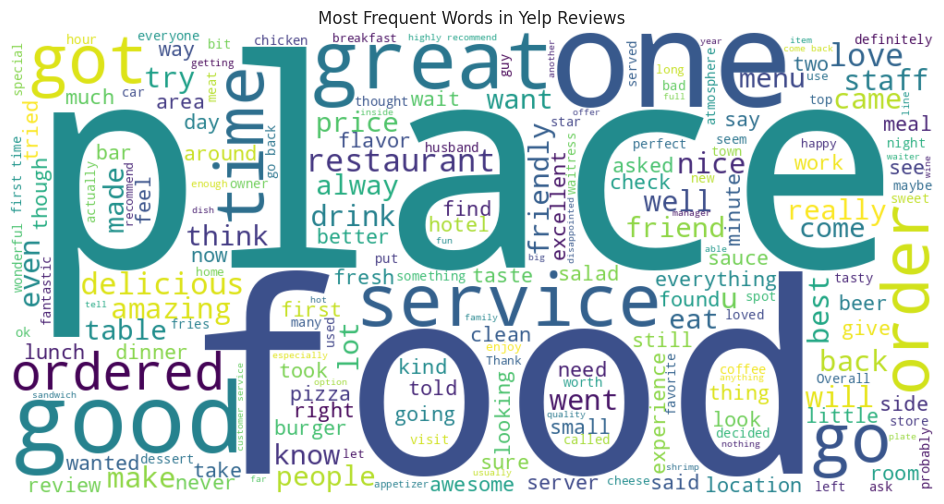


Positive reviews: 55852
Negative reviews: 15092

EDA Complete 


In [25]:
# Set seaborn style for plots and configure matplotlib figure size
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

# 1. Load JSON


print("Using already loaded 'review' DataFrame for EDA...")

# Create a copy of the 'review' DataFrame, which was loaded earlier, for EDA purposes
df = review.copy()

print("Original shape (after copying loaded review df):", df.shape)

# 2. Basic Info


print("\n===== DATA INFO =====")
# Display general information about the DataFrame, including column data types and non-null counts
print(df.info())

print("\n===== MISSING VALUES =====")
# Show the count of missing values for each column in the DataFrame
print(df.isnull().sum())

# 3. Star Rating Distribution


print("\n===== STAR DISTRIBUTION =====")
# Display the frequency of each star rating
print(df['stars'].value_counts())

# Create a count plot to visualize the distribution of star ratings
plt.figure()
sns.countplot(x='stars', data=df)
plt.title("Star Rating Distribution")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.savefig("stars_distribution.png") # Save the plot to a file
plt.show()

# 4. Text Feature Engineering


print("\nCreating text features...")

# Calculate the length of each review text and store it in a new 'review_length' column
df['review_length'] = df['text'].astype(str).apply(len)
# Calculate the number of words in each review text and store it in a new 'word_count' column
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

# Display descriptive statistics for the newly created text features
print(df[['review_length', 'word_count']].describe())

# Create a histogram to visualize the distribution of word counts
plt.figure()
sns.histplot(df['word_count'], bins=50)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.savefig("wordcount_distribution.png") # Save the plot to a file
plt.show()

# 5. Reviews Over Time


print("\nProcessing dates...")

# Convert the 'date' column to datetime objects, coercing errors to NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Extract the year from the 'date' column and store it in a new 'year' column
df['year'] = df['date'].dt.year

# Plot the number of reviews per year as a line chart
plt.figure()
df['year'].value_counts().sort_index().plot(kind='line')
plt.title("Reviews Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.savefig("reviews_per_year.png") # Save the plot to a file
plt.show()

# 6. Correlation Heatmap


# Select only numerical columns from the DataFrame
numeric_cols = df.select_dtypes(include=np.number)

# Create a heatmap to visualize the correlation matrix of numerical columns
plt.figure()
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("correlation_heatmap.png") # Save the plot to a file
plt.show()


# 7. WordCloud


print("\nGenerating WordCloud...")

# Concatenate all review texts into a single string for word cloud generation
text_data = " ".join(df['text'].dropna().astype(str))

# Generate a word cloud from the combined text data
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    max_words=200 # Limit to the top 200 most frequent words
).generate(text_data)

# Display the generated word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Turn off axis labels
plt.title("Most Frequent Words in Yelp Reviews")
plt.savefig("wordcloud.png") # Save the plot to a file
plt.show()


# 8. Sentiment Proxy (Stars Based)


# Filter reviews with 4 or 5 stars as positive sentiment
positive = df[df['stars'] >= 4]
# Filter reviews with 1 or 2 stars as negative sentiment
negative = df[df['stars'] <= 2]

# Print the count of positive and negative reviews
print("\nPositive reviews:", len(positive))
print("Negative reviews:", len(negative))

print("\nEDA Complete ")

### 5.4. User

In [26]:
user_df = user.head(1000).copy()

num_cols_user = user_df.select_dtypes(include=['int64','float64']).columns
cat_cols_user = user_df.select_dtypes(include=['object']).columns

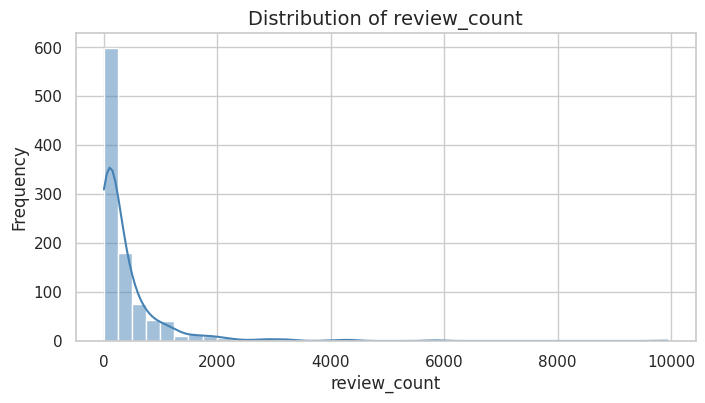

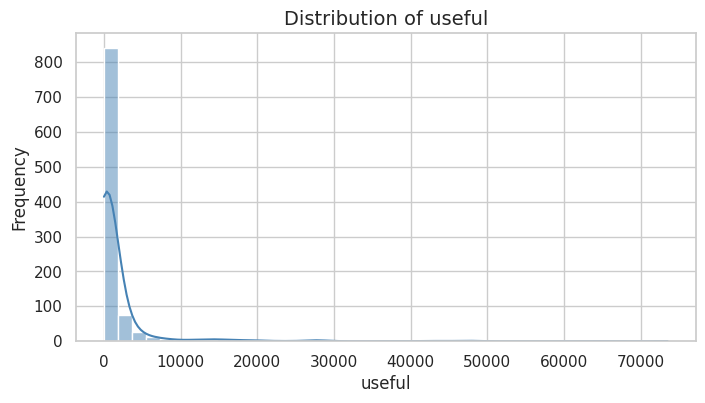

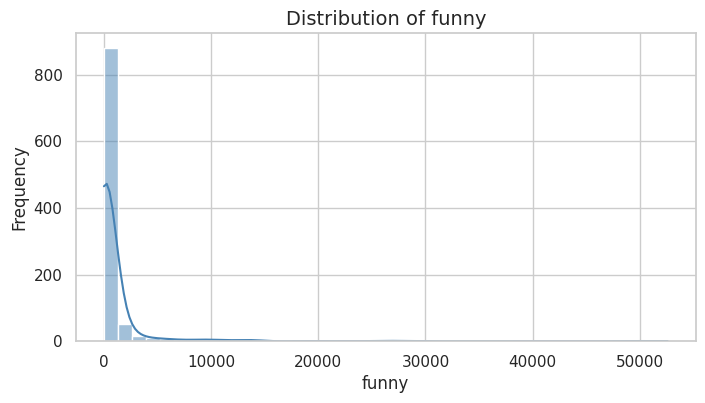

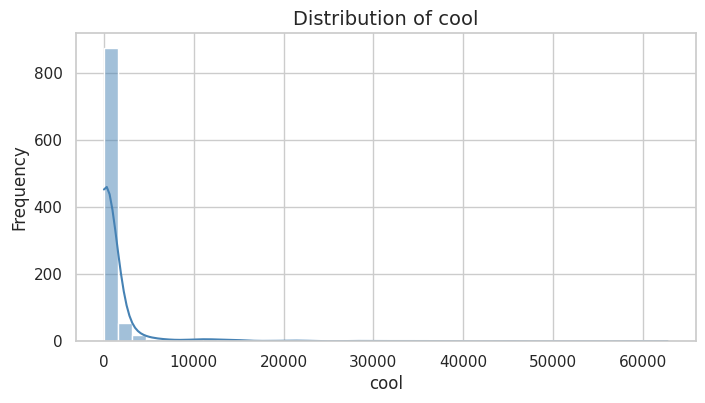

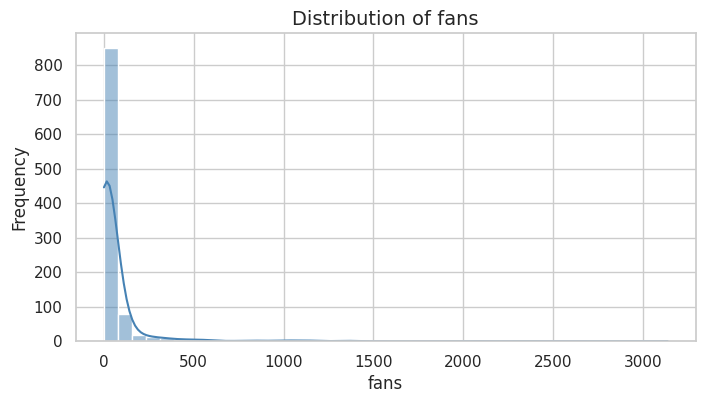

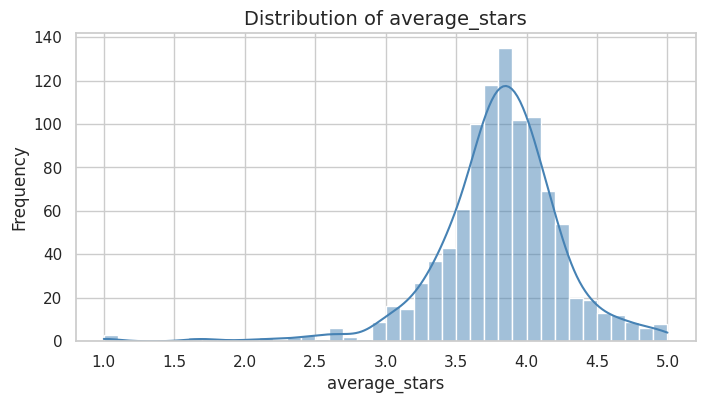

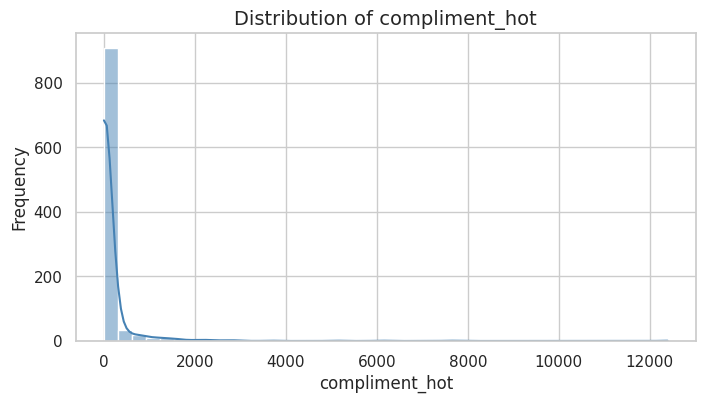

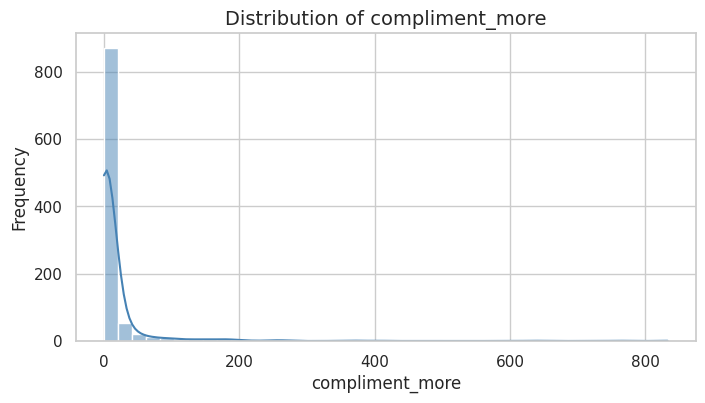

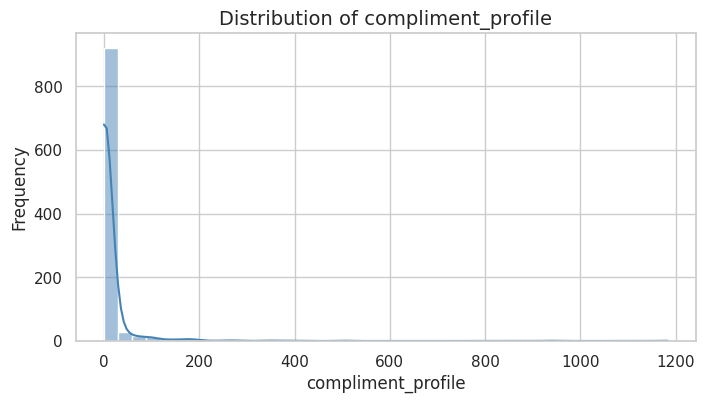

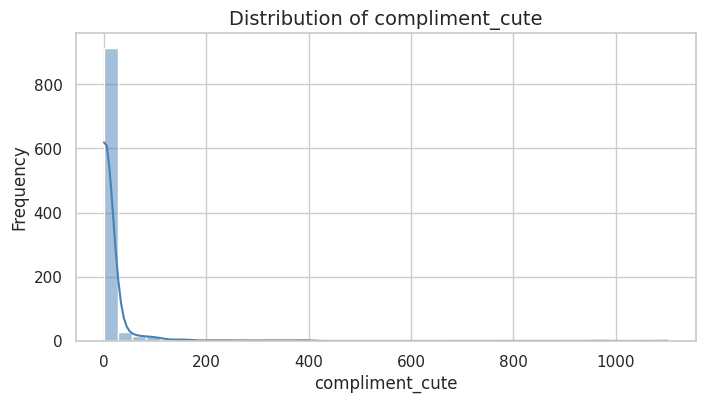

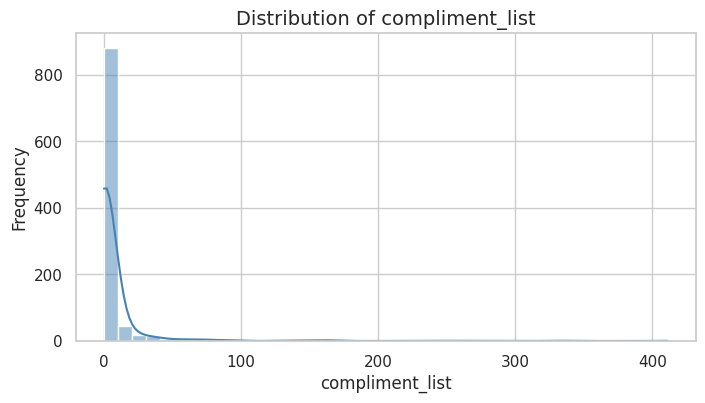

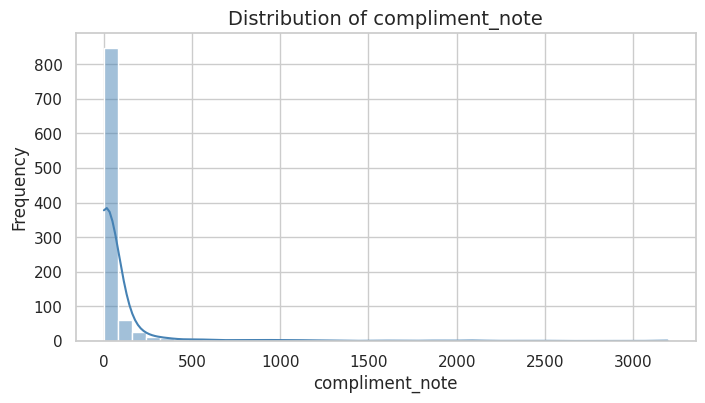

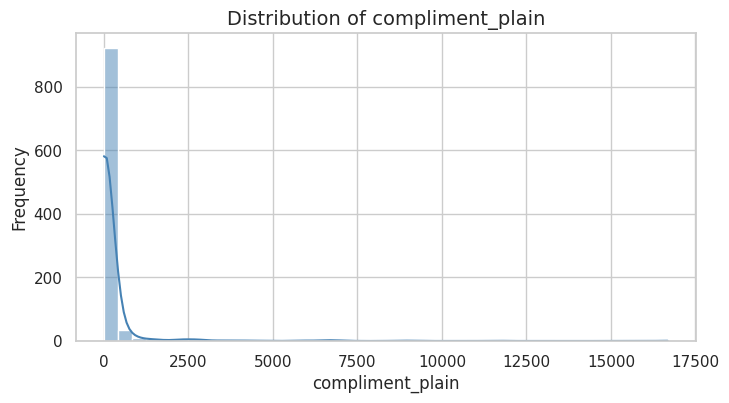

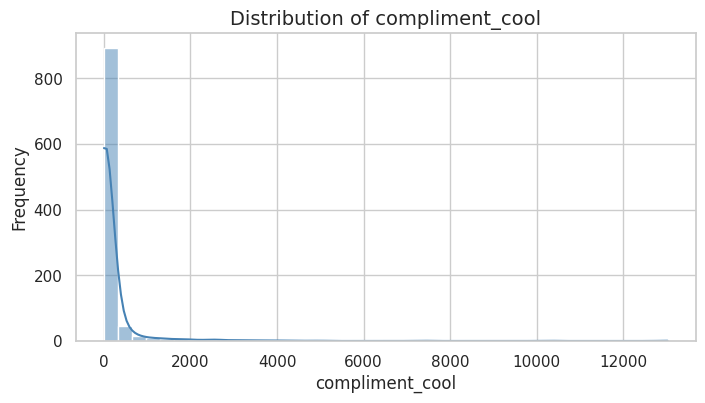

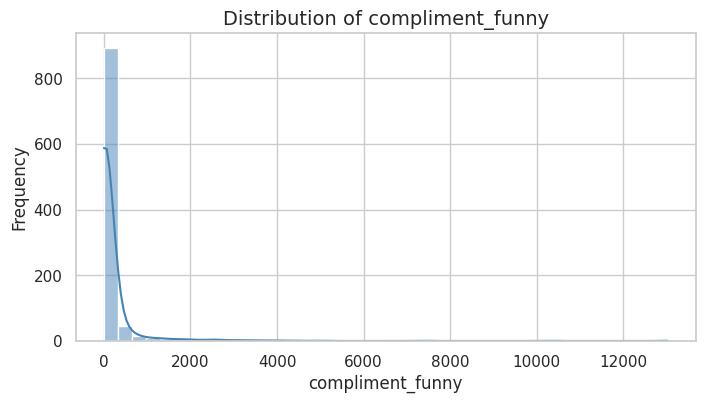

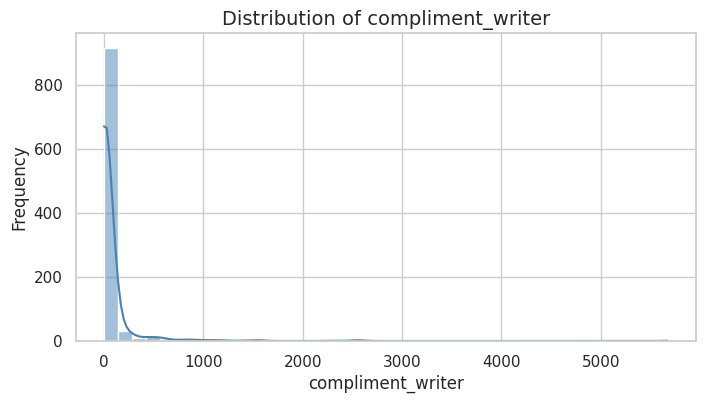

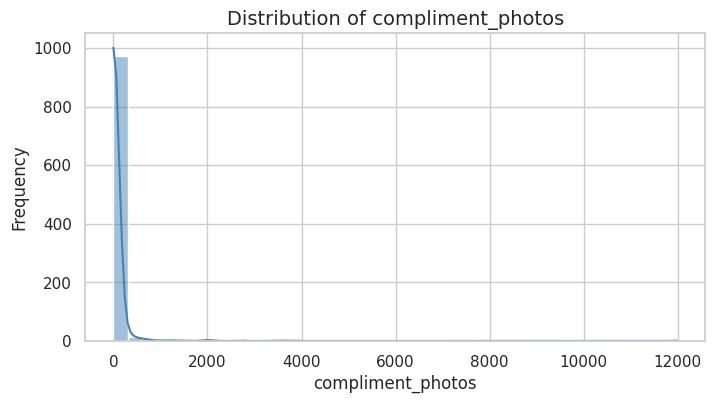

In [27]:
# Numeric
for col in num_cols_user:
    plt.figure(figsize=(8,4))
    sns.histplot(user_df[col], kde=True, bins=40, color='steelblue')
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

#### Bivariate Analysis

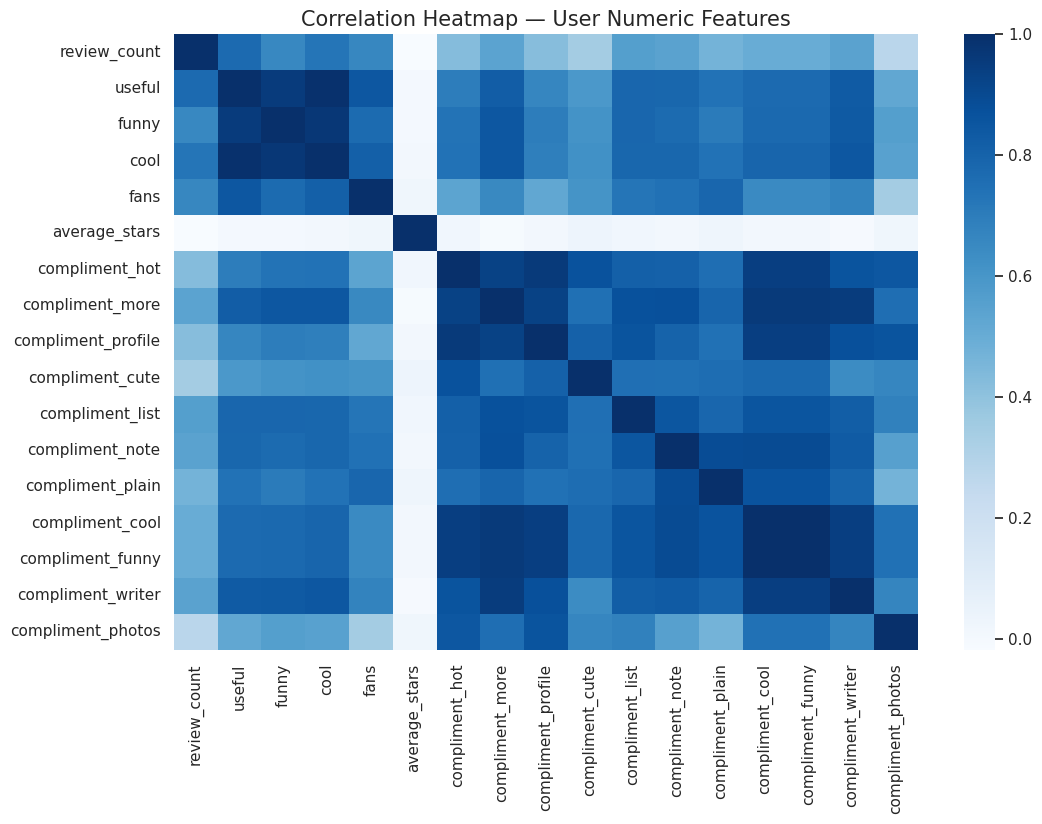

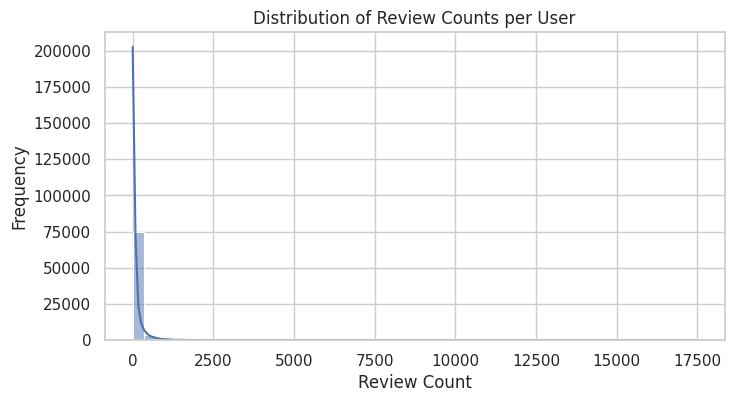

In [28]:
# Define user_df and num_cols_user for the correlation heatmap (using a sample)
num_cols_user = user_df.select_dtypes(include=['int64','float64']).columns

plt.figure(figsize=(12,8))
sns.heatmap(user_df[num_cols_user].corr(), annot=False, cmap="Blues")
plt.title("Correlation Heatmap — User Numeric Features", fontsize=15)
plt.show()

#### Advance Analysis

# Define user_clean for the advanced analysis (cleaned full user data)
# These steps are replicated from the original user data cleaning cell (UURTPcj-Z8C_)
user_clean = user.drop(columns=['friends'], errors='ignore')
user_clean['name'] = user_clean['name'].fillna('Unknown')
user_clean['elite'] = user_clean['elite'].fillna('None')
user_clean['yelping_since'] = pd.to_datetime(user_clean['yelping_since'], errors='coerce')
user_clean = user_clean.drop_duplicates(subset='user_id')

# Distribution of review counts
plt.figure(figsize=(8,4))
sns.histplot(user_clean['review_count'], bins=50, kde=True)
plt.title('Distribution of Review Counts per User')
plt.xlabel('Review Count')
plt.ylabel('Frequency')
plt.show()

#### Advance Analysis

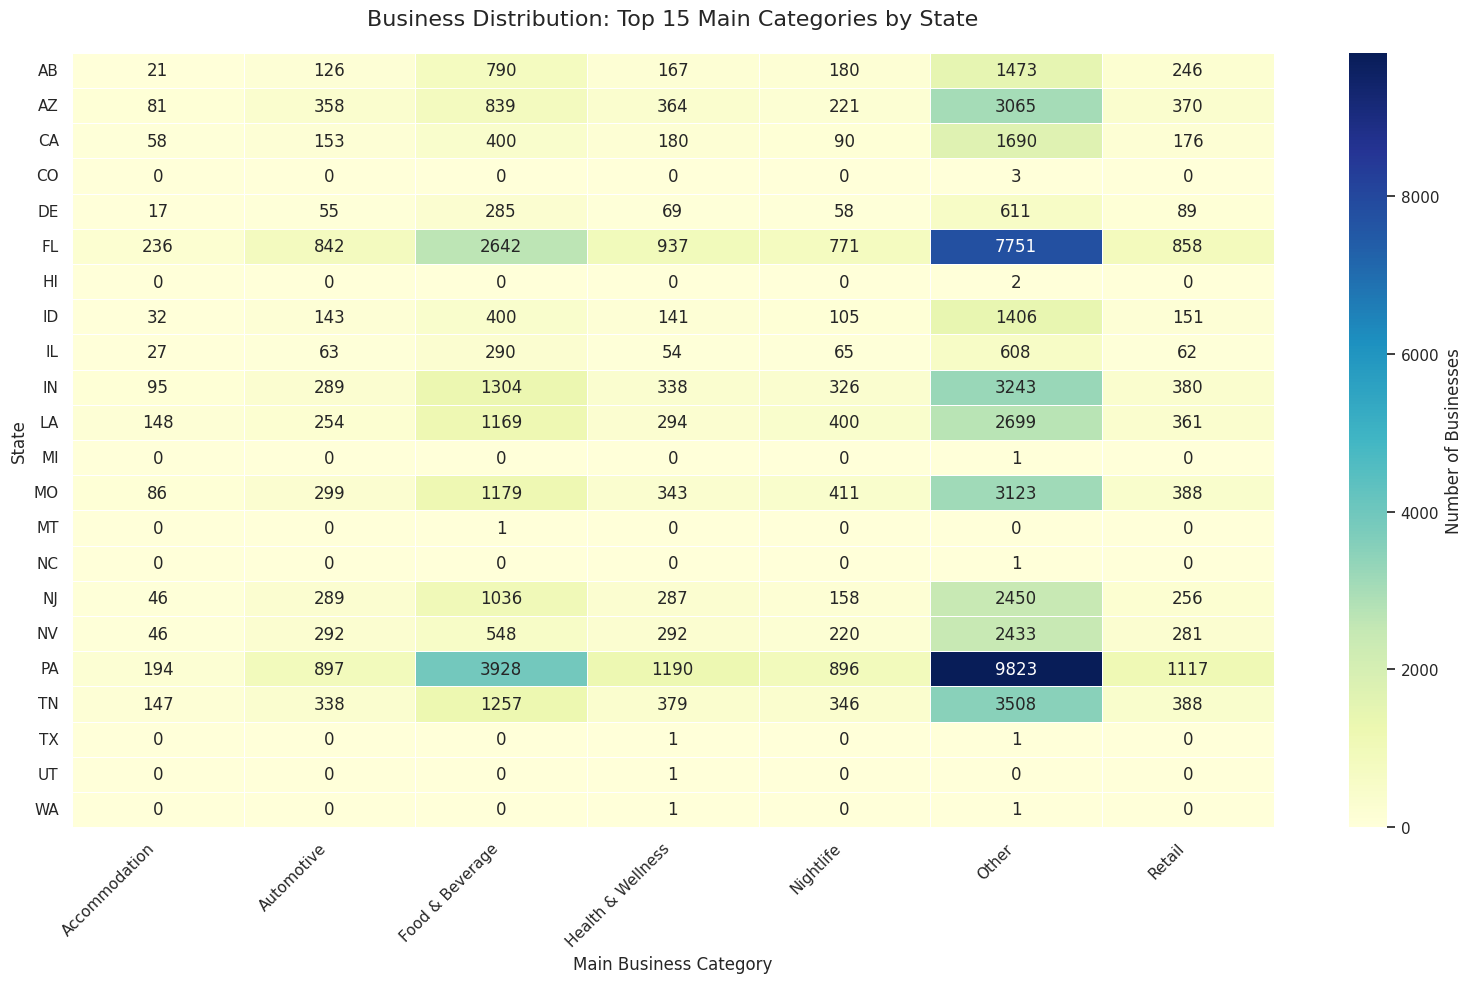

In [29]:
# Ensure df refers to the business DataFrame for this analysis
df = business.copy()

# --- Create 'main_cat' column (moved from cleaning step for self-containment) ---
df['main_cat'] = df['categories'].apply(
    lambda x: str(x).split(',')[0].strip() if pd.notnull(x) else 'Unknown'
)

def map_business_category(category):
    category = str(category).lower()
    if any(k in category for k in ['restaurant', 'food', 'cafe', 'pizza', 'coffee']):
        return 'Food & Beverage'
    if any(k in category for k in ['health', 'clinic', 'fitness', 'spa']):
        return 'Health & Wellness'
    if any(k in category for k in ['hotel', 'inn', 'bnb']):
        return 'Accommodation'
    if any(k in category for k in ['bar', 'nightlife', 'pub']):
        return 'Nightlife'
    if any(k in category for k in ['shop', 'store', 'retail']):
        return 'Retail'
    if any(k in category for k in ['auto', 'car', 'mechanic']):
        return 'Automotive'
    return 'Other'

df['main_cat'] = df['main_cat'].apply(map_business_category)

# --- ADAPTED OPTIMIZED HEATMAP CODE for Business Data ---

# 1. Identify the Top 15 most common business categories
top_categories = df['main_cat'].value_counts().nlargest(15).index

# 2. Filter dataset and create a pivot table (State vs. Main Category)
pivot_data = df[df['main_cat'].isin(top_categories)].groupby(['state', 'main_cat']).size().unstack(fill_value=0)

# Optional: Sort states alphabetically for consistent display
pivot_data = pivot_data.sort_index()

# 3. Create the Heatmap
plt.figure(figsize=(16, 10)) # Adjust figure size for better readability
sns.heatmap(pivot_data,
            annot=True,     # Show the actual counts in each cell
            fmt='d',        # Use integers for the numbers
            cmap='YlGnBu',  # Use a suitable color palette
            linewidths=.5,  # Add thin lines between cells
            cbar_kws={'label': 'Number of Businesses'})

plt.title('Business Distribution: Top 15 Main Categories by State', fontsize=16, pad=20)
plt.ylabel('State', fontsize=12)
plt.xlabel('Main Business Category', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate category names for readability
plt.yticks(rotation=0) # Keep state names horizontal
plt.tight_layout() # Prevents labels from being cut off
plt.show()

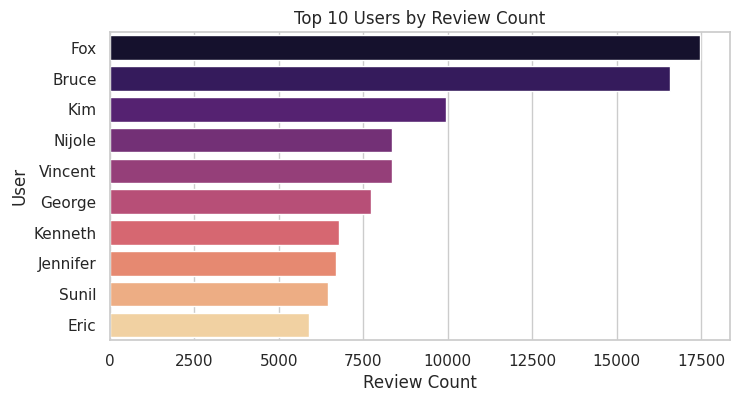

In [30]:
# Top users by review count
top_users = user_clean.nlargest(10, 'review_count')[['name','review_count']]
plt.figure(figsize=(8,4))
sns.barplot(data=top_users, x='review_count', y='name', palette='magma')
plt.title('Top 10 Users by Review Count')
plt.xlabel('Review Count')
plt.ylabel('User')
plt.show()

### 5.5. Tips

In [31]:
# Tip
tip_df = tip.head(1000).copy()   #loaded tip dataset

In [32]:
# Time Series
tip_df['year'] = tip_df['date'].dt.year

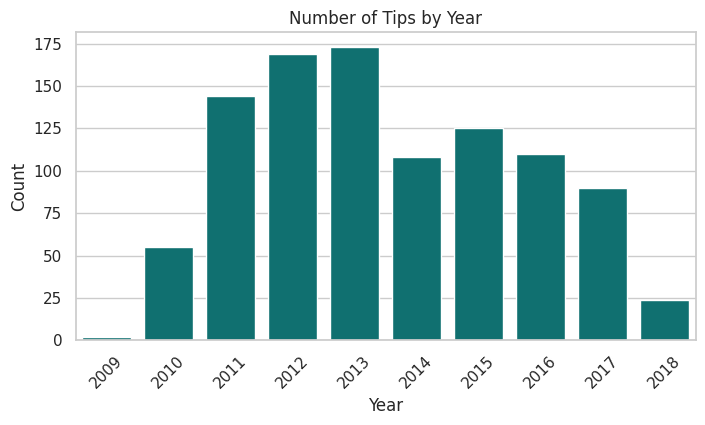

In [33]:
plt.figure(figsize=(8,4))
sns.countplot(x='year', data=tip_df, color='teal')
plt.title("Number of Tips by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

#### Bivariate Analysis

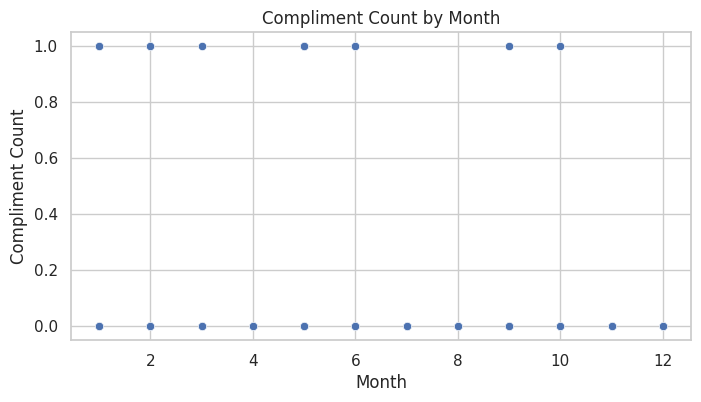

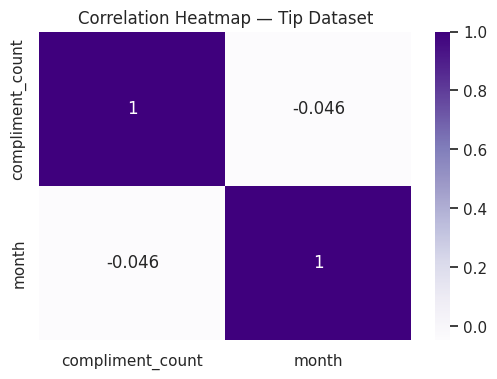

In [34]:
# Numeric vs Numeric
tip_df['month'] = tip_df['date'].dt.month

plt.figure(figsize=(8,4))
sns.scatterplot(x='month', y='compliment_count', data=tip_df)
plt.title("Compliment Count by Month")
plt.xlabel("Month")
plt.ylabel("Compliment Count")
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(tip_df[['compliment_count','month']].corr(), annot=True, cmap="Purples")
plt.title("Correlation Heatmap — Tip Dataset")
plt.show()